In [1]:
import math
import random
from collections import defaultdict
from pprint import pprint

# Prevent future/deprecation warnings from showing in output
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
import matplotlib.pyplot as plt

# Set global styles for plots
sns.set_style(style='white')
sns.set_context(context='notebook', font_scale=1.3, rc={'figure.figsize': (16,9)})

In [2]:
#SET FILE PATH
path_to_file = "bloodclot_controversy_coding_VALIDATION_actor.csv"

In [3]:
#READ & FORMAT DATA - CHECK IT'S ACTUALLY DETECTING IT
df = pd.read_csv(path_to_file, encoding='utf-8')
df.head()

,headline,label
0,"[UPDATE] @DrZweliMkhize: ""In South Africa, we ...",4
1,"[UPDATE] @DrZweliMkhize: ""In South Africa, we ...",4
2,4:27pm - SA publishes vaccination roadmap incl...,4
3,#BREAKING: Health Canada says a new and extrem...,2
4,Ever thought of blood clots before #smoking? T...,2


In [5]:
#PREPARE FOR TRAINING - SPLIT DATA 20-TRAIN /80-TEST

from sklearn.model_selection import train_test_split

X = df.headline
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
#THIS TOKENISES WORDS IN TWEETS AS NUMBERS (VECTORISE)

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=1000000,binary=False)

X_train_vect = vect.fit_transform(X_train)

In [7]:
#SEE NUMBER OF LABELS & ACCURACY IF ONLY USING 1 LABEL

counts = df.label.value_counts()
print(counts)

print("\nPredicting only 1 = {:.2f}% accuracy".format(counts[1] / sum(counts) * 100))

2    23592
4    19639
1     7861
3      361
Name: label, dtype: int64

Predicting only 1 = 15.28% accuracy


In [8]:
#SET OVERBALANCE FOR TRAINING DATA ONLY
from imblearn.over_sampling import SMOTE 

In [9]:
sm = SMOTE()

In [10]:
X_train_res, y_train_res = sm.fit_resample(X_train_vect, y_train)

In [11]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(1, 18883), (2, 18883), (3, 18883), (4, 18883)]


In [12]:
#IMPORT NAIVE BAYES MODEL & FIT TO TRAINING DATA

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_res, y_train_res)

nb.score(X_train_res, y_train_res)

0.8668776147857862

In [13]:
#VECTORISE TEST SET - NO OVERSAMPLE

X_test_vect = vect.transform(X_test)

y_pred = nb.predict(X_test_vect)

y_pred

array([2, 2, 4, ..., 1, 1, 2], dtype=int64)

In [14]:
#RUN AND OBTAIN ACCURACY, F1 and Confusion Matrix

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred, average="micro") * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 86.40%

F1 Score: 86.40

COnfusion Matrix:
 [[1168  119   76  209]
 [  72 4134   52  451]
 [   8    9   51    7]
 [ 155  177   65 3538]]


In [15]:
#GET DATAFRAME LABELS

from sklearn.utils.multiclass import unique_labels
unique_labels(y_test)

array([1, 2, 3, 4], dtype=int64)

In [16]:
#combine labels with confusion matrix

def plot(y_true, y_pred):
    labels = unique_labels(y_test)
    column = [f'actual{label}' for label in labels]
    indices = [f'predicted{label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true,y_pred),
                         columns=column, index=indices)
    return table

In [17]:
plot(y_test, y_pred)

,actual1,actual2,actual3,actual4
predicted1,1168,119,76,209
predicted2,72,4134,52,451
predicted3,8,9,51,7
predicted4,155,177,65,3538


In [18]:
import seaborn as sns

In [19]:
#plot as heatmap

def plot2(y_true, y_pred):
    labels = unique_labels(y_test)
    column = [f'actual{label}' for label in labels]
    indices = [f'predicted{label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true,y_pred),
                         columns=column, index=indices)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

<AxesSubplot:>

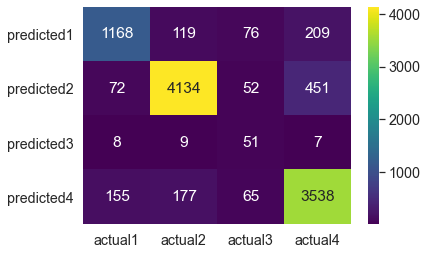

In [20]:
plot2(y_test, y_pred)

In [31]:
from sklearn.model_selection import ShuffleSplit

X = df.headline
y = df.label

ss = ShuffleSplit(n_splits=10, test_size=0.2)
sm = SMOTE()

accs = []
f1s = []
cms = []

for train_index, test_index in ss.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Oversample - change from sample to resample
    X_train_res, y_train_res = sm.fit_resample(X_train_vect, y_train)
    
    # Fit Naive Bayes on the vectorized X with y train labels, 
    # then predict new y labels using X test
    nb.fit(X_train_res, y_train_res)
    y_pred = nb.predict(X_test_vect)
    
    # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred, average = "micro"))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) /len(cms)))

#print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))


Average accuracy across folds: 86.47%

Average F1 score across folds: 86.47%

Average Confusion Matrix across folds: 
 [[1182.7  122.9   68.6  214. ]
 [  85.  4139.5   48.   434.5]
 [   4.8   11.4   49.     9.6]
 [ 155.2  168.2   70.3 3527.3]]


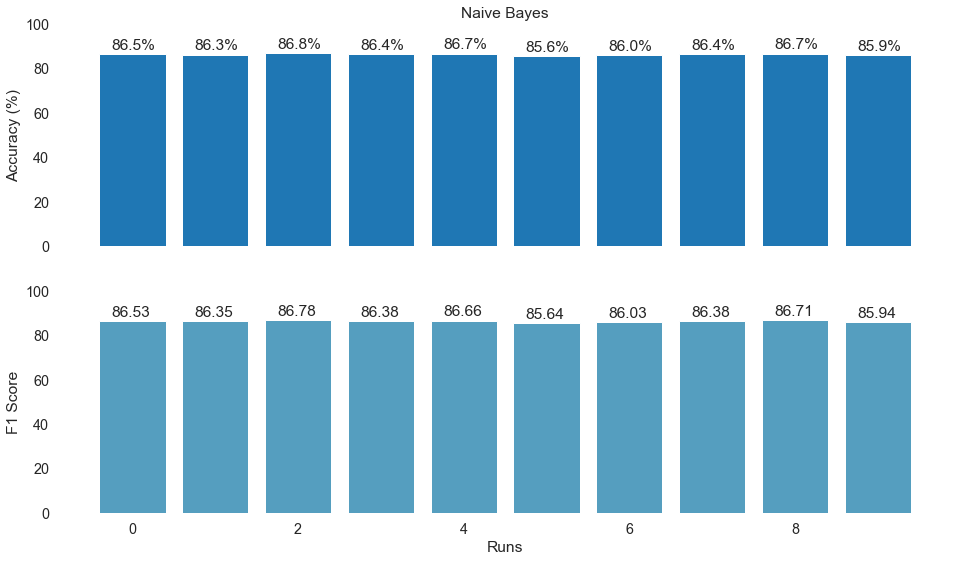

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))

acc_scores = [round(a * 100, 1) for a in accs]
f1_scores = [round(f * 100, 2) for f in f1s]

x1 = np.arange(len(acc_scores))
x2 = np.arange(len(f1_scores))

ax1.bar(x1, acc_scores)
ax2.bar(x2, f1_scores, color='#559ebf')

# Place values on top of bars
for i, v in enumerate(list(zip(acc_scores, f1_scores))):
    ax1.text(i - 0.25, v[0] + 2, str(v[0]) + '%')
    ax2.text(i - 0.25, v[1] + 2, str(v[1]))

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Naive Bayes')
ax1.set_ylim([0, 100])

ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Runs')
ax2.set_ylim([0, 100])

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation

plt.show()